# 1. Setup

In [ ]:
#DOCME:
#conda install -c conda-forge cudatoolkit=11.2 cudnn=8.1.0
# Anything above 2.10 is not supported on the GPU on Windows Native
#python -m pip install "tensorflow<2.11"
#!pip install opencv-python matplotlib

## 1.1 Install Dependencies

In [ ]:
# tensorflow funtional api
# funtional API is more flexible than sequencial API for building more hardcore DL models
# USING:Siamese Neural Network for One-shot Image Classification

## 1.2 Import Dependencies

In [1]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

## 1.3 Set GPU Growth

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

## 1.4 Create Folder Structures

In [4]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [10]:
# [x]: Make the directories
# os.makedirs(POS_PATH)
# os.makedirs(NEG_PATH)
# os.makedirs(ANC_PATH)

# 2. Collect Positives and Anchors

## 2.1 Untar Labelled Faces in the Wild Dataset

In [ ]:
# http://vis-www.cs.umass.edu/lfw/

In [7]:
# [x]:Uncompress Tar GZ Labelled Faces in the Wild Dataset
#!tar -xf lfw.tgz

In [11]:
# [x]: Move LFW Images to the following repository data/negative
# for directory in os.listdir('lfw'):
#     for file in os.listdir(os.path.join('lfw', directory)):
#         EX_PATH = os.path.join('lfw', directory, file)
#         NEW_PATH = os.path.join(NEG_PATH, file)
#         os.replace(EX_PATH, NEW_PATH)

## 2.2 Collect Positive and Anchor Classes

In [5]:
# Import uuid library to generate unique image names
import uuid

In [6]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\1ccb9a95-23d5-11ee-b021-001a7dda7115.jpg'

In [8]:
# #XXX: Establish a connection to the webcam test
# cap = cv2.VideoCapture(1)
# while cap.isOpened(): 
#     ret, frame = cap.read()
#     #Show image back to screen
#     cv2.imshow('Image Collection',frame)
#     #Breaking gracefully
#     if cv2.waitKey(1) & 0XFF == ord('q'):
#         break
        
# # Release the webcam
# cap.release()
# # Close the image show frame
# cv2.destroyAllWindows()

In [10]:
#plt.imshow(frame)

In [13]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(1)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

In [ ]:
plt.imshow(frame[120:120+250,200:200+250, :])

# 2.x NEW - Data Augmentation

In [14]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        data.append(img)
    
    return data

In [15]:
import os
import uuid

In [17]:
img_path = os.path.join(ANC_PATH, '7f98e4bf-23d7-11ee-b7e5-001a7dda7115.jpg')
img = cv2.imread(img_path)
augmented_images = data_aug(img)

for image in augmented_images:
    cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [18]:
for file_name in os.listdir(os.path.join(POS_PATH)):
    img_path = os.path.join(POS_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

# 3. Load and Preprocess Images

## 3.1 Get Image Directories

In [19]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(3000)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(3000)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(3000)

In [20]:
dir_test = anchor.as_numpy_iterator()

In [21]:
print(dir_test.next())

b'data\\anchor\\9078e706-23d7-11ee-88aa-001a7dda7115.jpg'


## 3.2 Preprocessing - Scale and Resize

In [22]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

In [23]:
img = preprocess('data\\anchor\\9078e706-23d7-11ee-88aa-001a7dda7115.jpg')

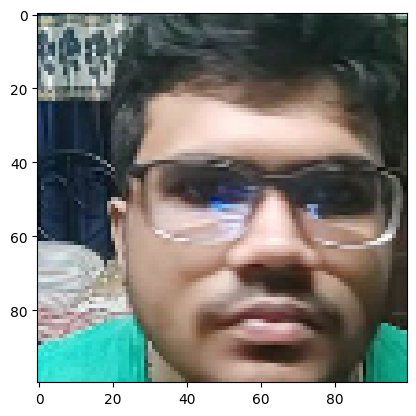

In [25]:
plt.imshow(img)

In [24]:
img.numpy().max() 

1.0

## 3.3 Create Labelled Dataset

In [26]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [27]:
#TODO: make positive for more than one user
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [28]:
samples = data.as_numpy_iterator()

In [31]:
example = samples.next()

In [32]:
example

(b'data\\anchor\\91f15b8a-23d7-11ee-8ed2-001a7dda7115.jpg',
 b'data\\positive\\76af5845-23d9-11ee-9f46-001a7dda7115.jpg',
 1.0)

## 3.4 Build Train and Test Partition

In [33]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [34]:
res = preprocess_twin(*example)

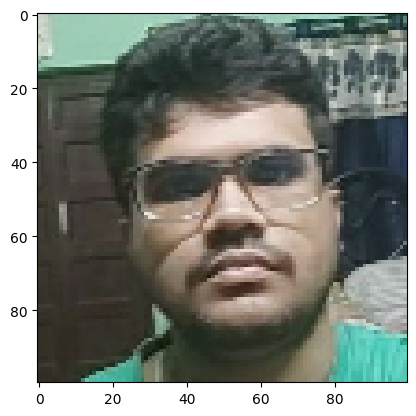

In [35]:
plt.imshow(res[1])

In [53]:
len(res)

3

In [37]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [38]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [39]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4. Model Engineering

## 4.1 Build Embedding Layer

In [40]:
inp = Input(shape=(100,100,3), name='input_image')

In [41]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [42]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [43]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [44]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [45]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [46]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [47]:
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [48]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [49]:
embedding = make_embedding()

In [50]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 17, 17, 128)       26

## 4.2 Build Distance Layer

In [51]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [52]:
l1 = L1Dist()

In [54]:
#l1(anchor_embedding, validation_embedding)

## 4.3 Make Siamese Model

In [55]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [56]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [57]:
siamese_layer = L1Dist()

In [58]:
distances = siamese_layer(inp_embedding, val_embedding)

In [59]:
classifier = Dense(1, activation='sigmoid')(distances)

In [60]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_2')>

In [61]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [62]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [63]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [64]:
siamese_model = make_siamese_model()

In [65]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# 5. Training

## 5.1 Setup Loss and Optimizer

In [66]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [67]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

## 5.2 Establish Checkpoints

In [68]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

## 5.3 Build Train Step Function

In [69]:
test_batch = train_data.as_numpy_iterator()

In [70]:
batch_1 = test_batch.next()

In [71]:
X = batch_1[:2]

In [72]:
y = batch_1[2]

In [73]:
y

array([1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1.],
      dtype=float32)

In [74]:
##tf.losses.BinaryCrossentropy??

In [75]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

## 5.4 Build Training Loop

In [76]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [77]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

## 5.5 Train the model

In [78]:
EPOCHS = 50

In [79]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
44/44 [==============================] - 26s 434ms/step
0.010831308 0.900277 0.91036415

 Epoch 2/50
44/44 [==============================] - 18s 411ms/step
0.09138828 0.9711816 0.9941003

 Epoch 3/50
44/44 [==============================] - 18s 411ms/step
0.07382712 0.97450423 1.0

 Epoch 4/50
44/44 [==============================] - 18s 415ms/step
0.052456655 0.9773371 0.9942363

 Epoch 5/50
44/44 [==============================] - 18s 418ms/step
0.014164801 0.98567337 0.9971014

 Epoch 6/50
44/44 [==============================] - 18s 412ms/step
0.043645985 0.9856322 0.997093

 Epoch 7/50
44/44 [==============================] - 18s 408ms/step
0.071943626 0.9942857 1.0

 Epoch 8/50
44/44 [==============================] - 18s 409ms/step
0.011558458 0.9858357 0.991453

 Epoch 9/50
44/44 [==============================] 

# 6. Evaluate Model

## 6.1 Import Metrics

In [80]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

## 6.2 Make Predictions

In [81]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [82]:
y_hat = siamese_model.predict([test_input, test_val])

1/1 [==============================] - 0s 21ms/step


In [83]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0]

In [84]:
y_true

array([0., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

## 6.3 Calculate Metrics

In [85]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [86]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [87]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 [==============================] - 0s 308ms/step
1.0 1.0


## 6.4 Viz Results

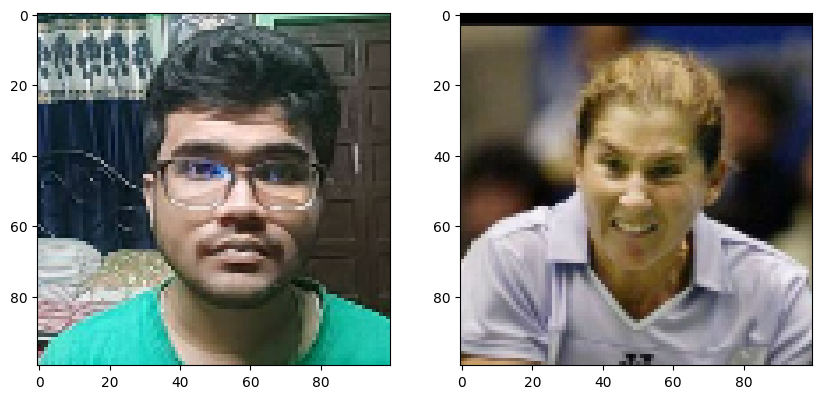

In [88]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

# 7. Save Model

In [89]:
# Save weights
siamese_model.save('siamesemodelv2.h5')

In [90]:
L1Dist

__main__.L1Dist

In [91]:
# Reload model 
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [92]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

1/1 [==============================] - 0s 105ms/step


array([[5.8917582e-10],
       [1.0000000e+00],
       [2.6818414e-11],
       [1.3047319e-10],
       [1.0000000e+00],
       [5.8646789e-11],
       [1.0000000e+00],
       [2.8170543e-12],
       [2.2219228e-10]], dtype=float32)

In [93]:
# View model summary
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# 8. Real Time Test

## 8.1 Verification Function

In [95]:
#application_data\verification_images

In [97]:
os.listdir(os.path.join('application_data', 'verification_images'))

[]

In [ ]:
#os.path.join('application_data', 'input_image', 'input_image.jpg')

In [98]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data\verification_images\46d0c498-23d8-11ee-80a4-001a7dda7115.jpg
application_data\verification_images\6a084ea9-23d9-11ee-883f-001a7dda7115.jpg
application_data\verification_images\6a089c97-23d9-11ee-8679-001a7dda7115.jpg
application_data\verification_images\6a08c38f-23d9-11ee-8bfa-001a7dda7115.jpg
application_data\verification_images\6a09d440-23d9-11ee-96ba-001a7dda7115.jpg
application_data\verification_images\6a14c943-23d9-11ee-983d-001a7dda7115.jpg
application_data\verification_images\6a15db0a-23d9-11ee-b002-001a7dda7115.jpg
application_data\verification_images\6a16c3b0-23d9-11ee-809b-001a7dda7115.jpg
application_data\verification_images\6a21ef3b-23d9-11ee-9932-001a7dda7115.jpg
application_data\verification_images\6a67a83e-23d9-11ee-b4f4-001a7dda7115.jpg
application_data\verification_images\6a68d0ea-23d9-11ee-a8f5-001a7dda7115.jpg
application_data\verification_images\6a69baaf-23d9-11ee-9818-001a7dda7115.jpg
application_data\verification_images\6a6a0896-23d9-11ee-9b04-001

In [99]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

## 8.2 OpenCV Real Time Verification

In [100]:
cap = cv2.VideoCapture(1)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
#         hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
#         h, s, v = cv2.split(hsv)

#         lim = 255 - 10
#         v[v > lim] = 255
#         v[v <= lim] -= 10
        
#         final_hsv = cv2.merge((h, s, v))
#         img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 19ms/step
True
1/1 [==============================] - 0s 19ms/step
False
1/1 [==============================] - 0s 19ms/step
True
1/1 [==============================] - 0s 18ms/step
False
1/1 [==============================] - 0s 17ms/step
True
1/1 [==============================] - 0s 18ms/step
True
1/1 [==============================] - 0s 19ms/step
False
1/1 [==============================] - 0s 19ms/step
False
1/1 [==============================] - 0s 18ms/step
True
1/1 [==============================] - 0s 18ms/step
True
1/1 [==============================] - 0s 18ms/step
False
1/1 [==============================] - 0s 19ms/step
False
1/1 [==============================] - 0s 20ms/step
False
1/1 [==============================] - 0s 22ms/step
True
1/1 [==============================] - 0s 18ms/step
True
1/1 [==============================] - 0s 23ms/step
True
1/1 [==============================] - 0s 23ms/step
False
1/1 [==================

In [101]:
np.sum(np.squeeze(results) > 0.9)

23

In [102]:
results

[array([[1.]], dtype=float32),
 array([[0.0249339]], dtype=float32),
 array([[0.99884677]], dtype=float32),
 array([[0.86733973]], dtype=float32),
 array([[0.007332]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.00449015]], dtype=float32),
 array([[0.0362851]], dtype=float32),
 array([[0.19475538]], dtype=float32),
 array([[0.7559551]], dtype=float32),
 array([[0.97963357]], dtype=float32),
 array([[0.07674309]], dtype=float32),
 array([[0.23440231]], dtype=float32),
 array([[0.25033966]], dtype=float32),
 array([[0.986785]], dtype=float32),
 array([[0.2612399]], dtype=float32),
 array([[0.07632716]], dtype=float32),
 array([[0.10991725]], dtype=float32),
 array([[0.98924834]], dtype=float32),
 array([[0.147092]], dtype=float32),
 array([[0.28499633]], dtype=float32),
 array([[0.34557426]], dtype=float32),
 array([[0.00078399]], dtype=float32),
 array([[0.00233798]], dtype=float32),
 array([[0.03505367]], dtype=float32),
 array([[0.00148592]], dtype=float32),
 array([[0.0